# SKIN CANCER CLASSIFICATION

# 1. Import Required Libraries

In [28]:
import warnings
warnings.filterwarnings("ignore")
import os, random, math, time, gc
from glob import glob
from tqdm import tqdm
import numpy as np
import pandas as pd
import cv2
from PIL import Image
import matplotlib.pyplot as plt

import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from torch.utils.data import Dataset, DataLoader, Sampler
from torchvision import transforms

import timm
import albumentations as A
from albumentations.pytorch import ToTensorV2

from sklearn.model_selection import train_test_split
from sklearn.metrics import (accuracy_score, precision_score, recall_score, f1_score,
                             roc_auc_score, precision_recall_curve, confusion_matrix)

In [29]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print("Using device:", device)

Using device: cuda


# 2. Configuration Class (CFG)

In [30]:
# Config
class CFG:
    SEED = 42
    DEVICE = device
    ISIC_CSV = "/kaggle/input/labels/ISIC_2024_Training_GroundTruth.csv"  
    IMG_DIR = "/kaggle/input/isic-2024-dataset/ISIC_2024_Training_Input"   

    # extreme imbalance in images so we downsample benign to a workable number
    BENIGN_DOWNSAMPLE = 10000   
    RANDOM_STATE = SEED

    IMG_SIZE = 320
    BATCH_SIZE = 12   
    EPOCHS = 30
    MODEL_NAME = "tf_efficientnet_b3_ns"   
    LR = 5e-5
    WEIGHT_DECAY = 1e-5
    NUM_WORKERS = 0
    OUT_DIR = "/kaggle/working/skin_outputs"
    os.makedirs(OUT_DIR, exist_ok=True)
    MODEL_SAVE = os.path.join(OUT_DIR, "best_model.pth")
    GRADCAM_DIR = os.path.join(OUT_DIR, "gradcam")
    os.makedirs(GRADCAM_DIR, exist_ok=True)

random.seed(CFG.SEED)
np.random.seed(CFG.SEED)
torch.manual_seed(CFG.SEED)
if torch.cuda.is_available():
    torch.cuda.manual_seed_all(CFG.SEED)
    torch.backends.cudnn.deterministic = True
    torch.backends.cudnn.benchmark = False

# 3. Load Dataset + Downsample Benign Class

In [31]:
# Load and Prepare Data
df_all = pd.read_csv(CFG.ISIC_CSV)[['isic_id','malignant']]
print("Original class counts:", df_all['malignant'].value_counts().to_dict())

benign_df = df_all[df_all['malignant']==0]
mal_df = df_all[df_all['malignant']==1]

Original class counts: {0.0: 400666, 1.0: 393}


In [32]:
# Downsample benign
benign_down = benign_df.sample(n=min(len(benign_df), CFG.BENIGN_DOWNSAMPLE), 
                                random_state=CFG.RANDOM_STATE)
df = pd.concat([benign_down, mal_df]).sample(frac=1, random_state=CFG.RANDOM_STATE).reset_index(drop=True)
print("After downsample counts:", df['malignant'].value_counts().to_dict())

After downsample counts: {0.0: 10000, 1.0: 393}


# 4. Train/Validation/Test Stratified Split

In [33]:
# Stratified split
from sklearn.model_selection import train_test_split
train_val_df, test_df = train_test_split(df, test_size=0.12, stratify=df['malignant'], 
                                          random_state=CFG.RANDOM_STATE)
train_df, val_df = train_test_split(train_val_df, test_size=0.12, stratify=train_val_df['malignant'], 
                                     random_state=CFG.RANDOM_STATE)

print(f"Train: {len(train_df)} (Mal: {int(train_df['malignant'].sum())})")
print(f"Val: {len(val_df)} (Mal: {int(val_df['malignant'].sum())})")
print(f"Test: {len(test_df)} (Mal: {int(test_df['malignant'].sum())})")

Train: 8047 (Mal: 304)
Val: 1098 (Mal: 42)
Test: 1248 (Mal: 47)


# 5. Display Sample Images

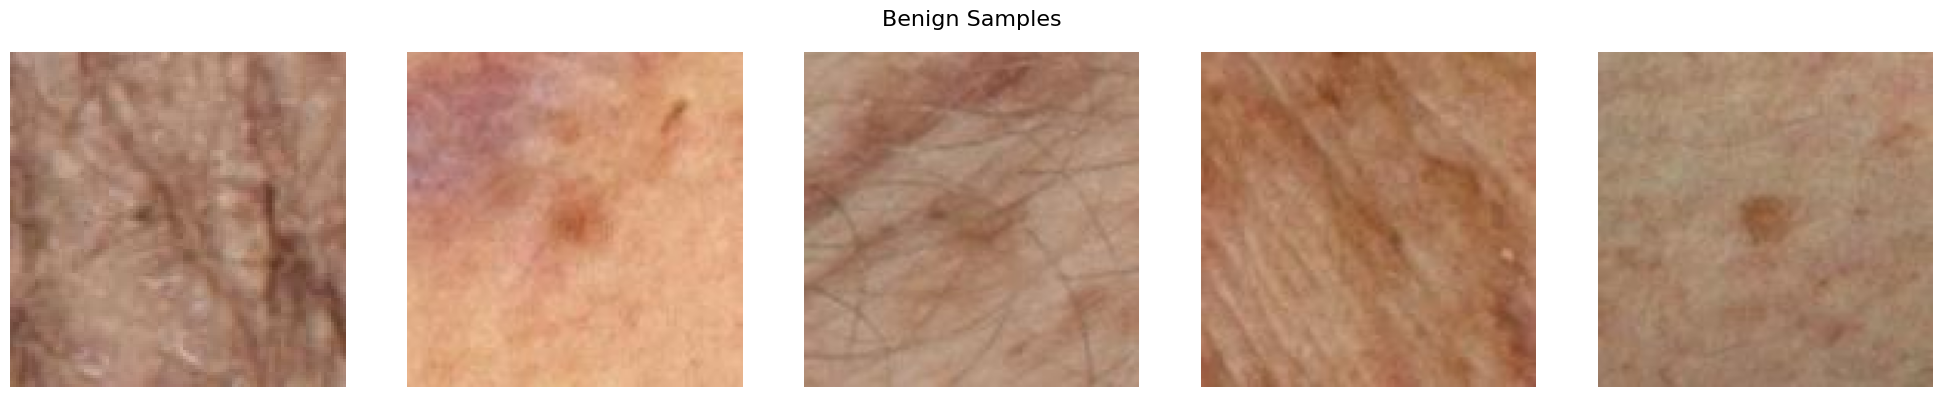

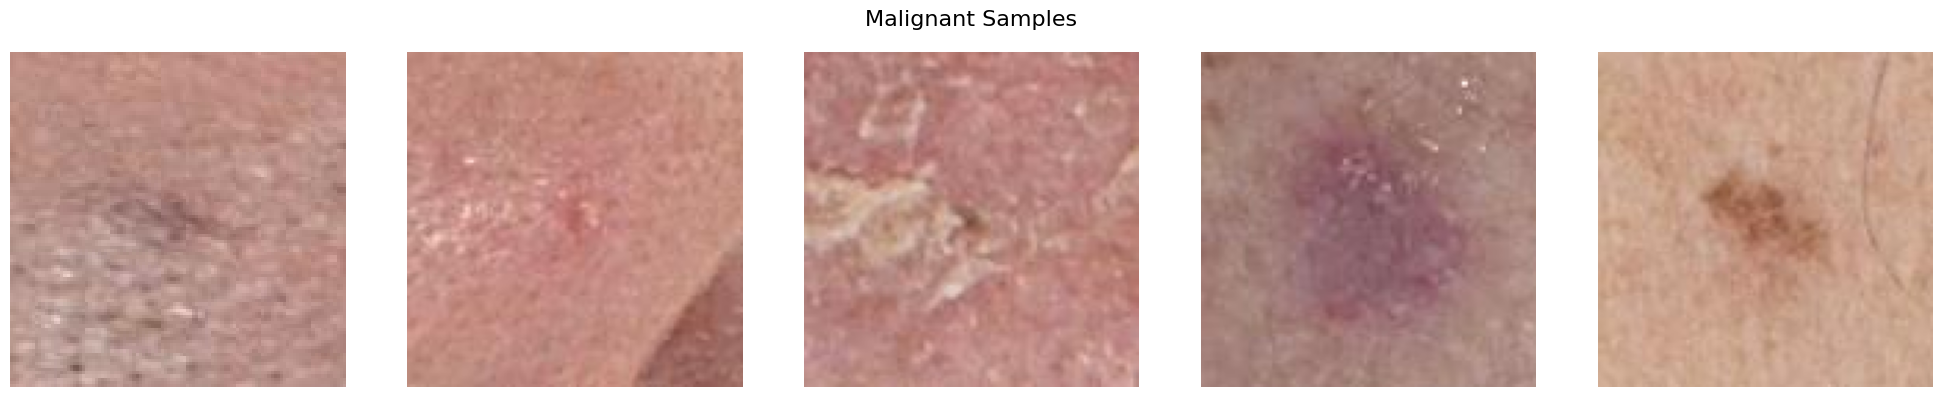

In [34]:
# Pick 5 samples from each class
sample_benign = df[df['malignant'] == 0].sample(5)
sample_malignant = df[df['malignant'] == 1].sample(5)

def show_images(rows, title):
    plt.figure(figsize=(20, 4))  
    for i, (_, row) in enumerate(rows.iterrows()):
        img_path = os.path.join(CFG.IMG_DIR, row['isic_id'] + ".jpg")
        img = Image.open(img_path)
        plt.subplot(1, 5, i+1)  
        plt.imshow(img)
        plt.axis('off')
    plt.suptitle(title, fontsize=16)
    plt.tight_layout()
    plt.show()

show_images(sample_benign, "Benign Samples")
show_images(sample_malignant, "Malignant Samples")

# 6. Albumentations Transformations

In [35]:
#Enhanced Augmentations with transforms
train_tf = A.Compose([
    A.Resize(CFG.IMG_SIZE, CFG.IMG_SIZE),
    A.HorizontalFlip(p=0.5),
    A.VerticalFlip(p=0.5),
    A.RandomRotate90(p=0.5),
    A.Transpose(p=0.3),
    A.ShiftScaleRotate(shift_limit=0.15, scale_limit=0.15, rotate_limit=45, p=0.7),
    A.OneOf([
        A.RandomBrightnessContrast(brightness_limit=0.3, contrast_limit=0.3, p=1),
        A.HueSaturationValue(hue_shift_limit=25, sat_shift_limit=40, val_shift_limit=25, p=1),
        A.RGBShift(r_shift_limit=20, g_shift_limit=20, b_shift_limit=20, p=1),
    ], p=0.7),
    A.OneOf([
        A.GaussNoise(var_limit=(10.0, 80.0), p=1),
        A.GaussianBlur(blur_limit=(3, 9), p=1),
        A.MotionBlur(blur_limit=5, p=1),
    ], p=0.4),
    A.CoarseDropout(max_holes=12, max_height=40, max_width=40, 
                     min_holes=4, min_height=20, min_width=20, p=0.4),
    A.Normalize(mean=(0.485,0.456,0.406), std=(0.229,0.224,0.225)),
    ToTensorV2()
])

val_tf = A.Compose([
    A.Resize(CFG.IMG_SIZE, CFG.IMG_SIZE),
    A.Normalize(mean=(0.485,0.456,0.406), std=(0.229,0.224,0.225)),
    ToTensorV2()
])

# 7. Skin Dataset Class

In [36]:
#Dataset returns image IDs for Grad-CAM
class SkinDataset(Dataset):
    def __init__(self, df, transform):
        self.df = df.reset_index(drop=True)
        self.transform = transform

    def __len__(self):
        return len(self.df)

    def __getitem__(self, idx):
        row = self.df.iloc[idx]
        img_id = str(row['isic_id'])
        path = os.path.join(CFG.IMG_DIR, img_id + ".jpg")
        
        try:
            img = cv2.imread(path)
            if img is None:
                raise ValueError("Image is None")
            img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
        except:
            img = np.zeros((CFG.IMG_SIZE, CFG.IMG_SIZE, 3), dtype=np.uint8)
        
        img_t = self.transform(image=img)['image']
        label = torch.tensor(row['malignant'], dtype=torch.float32)
        
        return img_t, label, img_id  

# 8. Balanced Batch Sampler

In [37]:
#Balanced Sampler with better oversampling
class BalancedBatchSampler(Sampler):
    def __init__(self, labels, batch_size, oversample_factor=15):
        self.labels = np.array(labels)
        self.batch_size = batch_size
        
        self.pos_idx = np.where(self.labels == 1)[0]
        self.neg_idx = np.where(self.labels == 0)[0]
        
        #50/50 split in each batch
        self.n_pos_per_batch = batch_size // 2
        self.n_neg_per_batch = batch_size - self.n_pos_per_batch
        
        #More oversampling for minority class
        self.n_batches = (len(self.pos_idx) * oversample_factor) // self.n_pos_per_batch
        
        print(f"BalancedBatchSampler: {self.n_batches} batches/epoch")
        print(f"  Positive per batch: {self.n_pos_per_batch}, Negative per batch: {self.n_neg_per_batch}")
        print(f"  Minority oversampling: ~{(self.n_batches * self.n_pos_per_batch) / len(self.pos_idx):.1f}x")

    def __iter__(self):
        for _ in range(self.n_batches):
            pos_samples = np.random.choice(self.pos_idx, self.n_pos_per_batch, replace=True)
            neg_samples = np.random.choice(self.neg_idx, self.n_neg_per_batch, replace=True)
            
            batch = np.concatenate([pos_samples, neg_samples])
            np.random.shuffle(batch)
            
            yield from batch.tolist()

    def __len__(self):
        return self.n_batches * self.batch_size

# 9. Create Datasets & DataLoaders

In [38]:
# Create Datasets
train_dataset = SkinDataset(train_df, train_tf)
val_dataset = SkinDataset(val_df, val_tf)
test_dataset = SkinDataset(test_df, val_tf)

train_sampler = BalancedBatchSampler(
    train_df['malignant'].values, 
    batch_size=CFG.BATCH_SIZE,
    oversample_factor=12  
)

BalancedBatchSampler: 608 batches/epoch
  Positive per batch: 6, Negative per batch: 6
  Minority oversampling: ~12.0x


In [39]:
#Simplified DataLoader without multiprocessing
train_loader = DataLoader(
    train_dataset, 
    batch_size=CFG.BATCH_SIZE,
    sampler=train_sampler,
    num_workers=CFG.NUM_WORKERS,
    pin_memory=True if torch.cuda.is_available() else False
)

val_loader = DataLoader(
    val_dataset, 
    batch_size=CFG.BATCH_SIZE*2, 
    shuffle=False, 
    num_workers=CFG.NUM_WORKERS,
    pin_memory=True if torch.cuda.is_available() else False
)

test_loader = DataLoader(
    test_dataset, 
    batch_size=CFG.BATCH_SIZE*2, 
    shuffle=False, 
    num_workers=CFG.NUM_WORKERS,
    pin_memory=True if torch.cuda.is_available() else False
)

print(f"\nDataLoaders: train={len(train_loader)}, val={len(val_loader)}, test={len(test_loader)}")


DataLoaders: train=608, val=46, test=52


# 10. Asymmetric Focal Loss

In [40]:
class AsymmetricFocalLoss(nn.Module):
    def __init__(self, alpha=0.30, gamma_pos=1.0, gamma_neg=3.0):  
        super().__init__()
        self.alpha = alpha
        self.gamma_pos = gamma_pos  
        self.gamma_neg = gamma_neg  

    def forward(self, logits, targets):
        probs = torch.sigmoid(logits)
        
        # Positive class loss
        pos_loss = -(1 - probs) ** self.gamma_pos * torch.log(probs + 1e-8) * targets
        
        # Negative class loss  
        neg_loss = -probs ** self.gamma_neg * torch.log(1 - probs + 1e-8) * (1 - targets)
        
        # Combine with alpha weighting
        loss = self.alpha * pos_loss + (1 - self.alpha) * neg_loss
        
        return loss.mean()

# 11. Attention-Enhanced EfficientNet Model

In [41]:
#Enhanced EfficientNet Model with Spatial + Channel Attention
#A custom architecture built on top of EfficientNet-B3.  
#Adds spatial attention, channel attention and a deeper classifier head.
class SpatialAttention(nn.Module):
    def __init__(self, kernel_size=7):
        super().__init__()
        self.conv = nn.Conv2d(2, 1, kernel_size, padding=kernel_size//2, bias=False)
        self.sigmoid = nn.Sigmoid()

    def forward(self, x):
        avg_out = torch.mean(x, dim=1, keepdim=True)
        max_out, _ = torch.max(x, dim=1, keepdim=True)
        x = torch.cat([avg_out, max_out], dim=1)
        x = self.conv(x)
        return self.sigmoid(x)

In [42]:
class EnhancedAttentionModel(nn.Module):
    def __init__(self, model_name, pretrained=True):
        super().__init__()
        self.backbone = timm.create_model(model_name, pretrained=pretrained, 
                                          num_classes=0, features_only=False)
        n_features = self.backbone.num_features
        
        #Spatial attention
        self.spatial_attn = SpatialAttention()
        
        #Channel attention
        self.channel_attn = nn.Sequential(
            nn.AdaptiveAvgPool2d(1),
            nn.Flatten(),
            nn.Linear(n_features, n_features // 8),
            nn.ReLU(),
            nn.Linear(n_features // 8, n_features),
            nn.Sigmoid()
        )
        
        #Enhanced classifier with more capacity
        self.classifier = nn.Sequential(
            nn.Dropout(0.5),
            nn.Linear(n_features, 512),
            nn.BatchNorm1d(512),
            nn.ReLU(),
            nn.Dropout(0.4),
            nn.Linear(512, 256),
            nn.BatchNorm1d(256),
            nn.ReLU(),
            nn.Dropout(0.3),
            nn.Linear(256, 1)
        )

    def forward(self, x):
        #get features before final pooling
        features = self.backbone.forward_features(x)
        
        #apply spatial attention
        spatial_weights = self.spatial_attn(features)
        features = features * spatial_weights
        
        #global average pooling
        features = F.adaptive_avg_pool2d(features, 1).flatten(1)
        
        #apply channel attention
        channel_weights = self.channel_attn(features.unsqueeze(-1).unsqueeze(-1))
        features = features * channel_weights
        
        return self.classifier(features).squeeze(1)

# 12) Model, optimizer, LR Scheduler and  mixed precision

In [43]:
# Create Model
model = EnhancedAttentionModel(CFG.MODEL_NAME, pretrained=True).to(CFG.DEVICE)
print(f"Model params: {sum(p.numel() for p in model.parameters()):,}")

Model params: 12,207,947


In [44]:
#Better optimizer with layer-wise learning rates
#Different learning rates for backbone vs head
backbone_params = []
head_params = []

for name, param in model.named_parameters():
    if 'backbone' in name:
        backbone_params.append(param)
    else:
        head_params.append(param)

optimizer = optim.AdamW([
    {'params': backbone_params, 'lr': CFG.LR},
    {'params': head_params, 'lr': CFG.LR * 10}  # Higher LR for head
], weight_decay=CFG.WEIGHT_DECAY)

In [45]:
# OneCycleLR for better convergence
scheduler = optim.lr_scheduler.OneCycleLR(
    optimizer, 
    max_lr=[CFG.LR, CFG.LR * 10],
    epochs=CFG.EPOCHS,
    steps_per_epoch=len(train_loader),
    pct_start=0.1,
    anneal_strategy='cos',
    div_factor=25.0,
    final_div_factor=1000.0
)

In [46]:
# Loss function
criterion = AsymmetricFocalLoss(alpha=0.30, gamma_pos=1.0, gamma_neg=3.0)

# Mixed precision
scaler = torch.cuda.amp.GradScaler(enabled=(CFG.DEVICE.type=='cuda'))

# 13) Training Function

In [47]:
def train_one_epoch(model, loader, optimizer, criterion, scaler, scheduler):
    model.train()
    running_loss = 0.0
    
    pbar = tqdm(loader, desc="Training", leave=False)
    for imgs, labels, _ in pbar:  
        imgs = imgs.to(CFG.DEVICE)
        labels = labels.to(CFG.DEVICE)
        
        optimizer.zero_grad()
        
        with torch.cuda.amp.autocast(enabled=(CFG.DEVICE.type=='cuda')):
            logits = model(imgs)
            loss = criterion(logits, labels)
        
        scaler.scale(loss).backward()
        scaler.unscale_(optimizer)
        torch.nn.utils.clip_grad_norm_(model.parameters(), 1.0)
        scaler.step(optimizer)
        scaler.update()
        
        # FIX #15: Step OneCycleLR every batch
        scheduler.step()
        
        running_loss += loss.item() * imgs.size(0)
        pbar.set_postfix({'loss': f'{loss.item():.4f}'})
    
    return running_loss / len(loader.dataset)

# 14) Validation Function

In [48]:
#Computes predictions, probabilities and stores image IDs.
@torch.no_grad()
def validate(model, loader):
    model.eval()
    all_preds = []
    all_labels = []
    all_ids = []
    
    for imgs, labels, img_ids in tqdm(loader, desc="Validating", leave=False):
        imgs = imgs.to(CFG.DEVICE)
        logits = model(imgs)
        probs = torch.sigmoid(logits)
        
        all_preds.extend(probs.cpu().numpy())
        all_labels.extend(labels.numpy())
        all_ids.extend(img_ids)
    
    return np.array(all_labels), np.array(all_preds), all_ids

# 15) Evaluation Metrics

In [49]:
#compute Accuracy, Precision, Recall, F1, AUC and confusion matrix.
def compute_metrics(y_true, y_probs, threshold=0.5):
    y_pred = (y_probs >= threshold).astype(int)
    
    acc = accuracy_score(y_true, y_pred)
    prec = precision_score(y_true, y_pred, zero_division=0)
    rec = recall_score(y_true, y_pred, zero_division=0)
    f1 = f1_score(y_true, y_pred, zero_division=0)
    
    try:
        auc = roc_auc_score(y_true, y_probs)
    except:
        auc = 0.0
    
    cm = confusion_matrix(y_true, y_pred)
    
    return {
        'acc': acc, 'prec': prec, 'rec': rec, 'f1': f1, 'auc': auc,
        'threshold': threshold, 'cm': cm
    }

# 16) Dynamic Threshold Selection

In [50]:
#Dynamic threshold that balances precision and recall
def find_best_threshold(y_true, y_probs, strategy='balanced_f1'):
    """Find optimal threshold using different strategies"""
    precisions, recalls, thresholds = precision_recall_curve(y_true, y_probs)
    
    if strategy == 'balanced_f1':
        # Maximize F1 score
        f1_scores = 2 * (precisions * recalls) / (precisions + recalls + 1e-10)
        best_idx = np.argmax(f1_scores)
        return float(thresholds[best_idx]) if best_idx < len(thresholds) else 0.5
    
    elif strategy == 'recall_80':
        # Target 80% recall
        valid_idx = recalls[:-1] >= 0.80
        if valid_idx.sum() > 0:
            valid_precisions = precisions[:-1][valid_idx]
            valid_thresholds = thresholds[valid_idx]
            best_idx = np.argmax(valid_precisions)
            return float(valid_thresholds[best_idx])
        # Fallback to best recall
        best_idx = np.argmax(recalls[:-1])
        return float(thresholds[best_idx]) if best_idx < len(thresholds) else 0.3
    
    else:  # 'high_recall'
        #Prioritize recall heavily (weighted F-beta with beta=2)
        beta = 2.0
        f_beta = (1 + beta**2) * (precisions * recalls) / (beta**2 * precisions + recalls + 1e-10)
        best_idx = np.argmax(f_beta)
        return float(thresholds[best_idx]) if best_idx < len(thresholds) else 0.5

# 17) Main Training loop

In [52]:
best_score = 0.0
best_epoch = -1
patience = 8
patience_counter = 0

print("\nStarting Training\n")
start_time = time.time()

for epoch in range(CFG.EPOCHS):
    epoch_start = time.time()
    
    # Train
    train_loss = train_one_epoch(model, train_loader, optimizer, criterion, scaler, scheduler)
    
    # Validate
    y_true, y_probs, _ = validate(model, val_loader)
    best_thr = find_best_threshold(y_true, y_probs, strategy='balanced_f1')  # BALANCED approach
    metrics = compute_metrics(y_true, y_probs, threshold=best_thr)
    
    # Print results
    epoch_time = time.time() - epoch_start
    print(f"Epoch {epoch+1:02d}/{CFG.EPOCHS} | "
          f"Loss: {train_loss:.4f} | "
          f"AUC: {metrics['auc']:.4f} | "
          f"F1: {metrics['f1']:.4f} | "
          f"Prec: {metrics['prec']:.4f} | "
          f"Rec: {metrics['rec']:.4f} | "
          f"Thr: {best_thr:.3f} | "
          f"Time: {epoch_time:.1f}s")
    
    #Equal weighting of metrics
    current_score = 0.33 * metrics['auc'] + 0.33 * metrics['f1'] + 0.34 * metrics['rec']
    
    if current_score > best_score:
        best_score = current_score
        best_epoch = epoch
        patience_counter = 0
        
        torch.save({
            'epoch': epoch,
            'model_state_dict': model.state_dict(),
            'optimizer_state_dict': optimizer.state_dict(),
            'best_score': best_score,
            'best_threshold': best_thr,
            'metrics': metrics
        }, CFG.MODEL_SAVE)
        
        print(f"----> Saved best model (Score: {current_score:.4f})")
    else:
        patience_counter += 1
        if patience_counter >= patience:
            print(f"\nEarly stopping at epoch {epoch+1}")
            break

total_time = (time.time() - start_time) / 60
print(f"Training Complete!")
print(f"Best Epoch: {best_epoch+1} | Best Score: {best_score:.4f}")
print(f"Total Time: {total_time:.1f} minutes")


Starting Training



Epoch 01/30 | Loss: 0.0806 | AUC: 0.8277 | F1: 0.3248 | Prec: 0.2533 | Rec: 0.4524 | Thr: 0.488 | Time: 139.8s
----> Saved best model (Score: 0.5341)


Epoch 02/30 | Loss: 0.0648 | AUC: 0.8869 | F1: 0.4423 | Prec: 0.3710 | Rec: 0.5476 | Thr: 0.630 | Time: 137.7s
----> Saved best model (Score: 0.6248)


Epoch 03/30 | Loss: 0.0520 | AUC: 0.8822 | F1: 0.4545 | Prec: 0.4348 | Rec: 0.4762 | Thr: 0.694 | Time: 137.7s


Epoch 04/30 | Loss: 0.0434 | AUC: 0.9075 | F1: 0.4571 | Prec: 0.5714 | Rec: 0.3810 | Thr: 0.669 | Time: 137.1s


Epoch 05/30 | Loss: 0.0388 | AUC: 0.9103 | F1: 0.4694 | Prec: 0.4107 | Rec: 0.5476 | Thr: 0.628 | Time: 138.5s
----> Saved best model (Score: 0.6415)


Epoch 06/30 | Loss: 0.0332 | AUC: 0.8859 | F1: 0.4494 | Prec: 0.4255 | Rec: 0.4762 | Thr: 0.602 | Time: 136.6s


Epoch 07/30 | Loss: 0.0310 | AUC: 0.8943 | F1: 0.4941 | Prec: 0.4884 | Rec: 0.5000 | Thr: 0.727 | Time: 137.2s


Epoch 08/30 | Loss: 0.0273 | AUC: 0.9108 | F1: 0.5067 | Prec: 0.5758 | Rec: 0.4524 | Thr: 0.784 | Time: 138.2s


Epoch 09/30 | Loss: 0.0237 | AUC: 0.9019 | F1: 0.4737 | Prec: 0.5294 | Rec: 0.4286 | Thr: 0.719 | Time: 138.2s


Epoch 10/30 | Loss: 0.0227 | AUC: 0.9112 | F1: 0.5128 | Prec: 0.5556 | Rec: 0.4762 | Thr: 0.698 | Time: 136.7s


Epoch 11/30 | Loss: 0.0210 | AUC: 0.8963 | F1: 0.5238 | Prec: 0.5238 | Rec: 0.5238 | Thr: 0.786 | Time: 137.6s
----> Saved best model (Score: 0.6467)


Epoch 12/30 | Loss: 0.0189 | AUC: 0.8995 | F1: 0.5250 | Prec: 0.5526 | Rec: 0.5000 | Thr: 0.675 | Time: 136.0s


Epoch 13/30 | Loss: 0.0171 | AUC: 0.9175 | F1: 0.5412 | Prec: 0.5349 | Rec: 0.5476 | Thr: 0.674 | Time: 137.2s
----> Saved best model (Score: 0.6675)


Epoch 14/30 | Loss: 0.0165 | AUC: 0.9173 | F1: 0.5176 | Prec: 0.5116 | Rec: 0.5238 | Thr: 0.819 | Time: 137.4s


Epoch 15/30 | Loss: 0.0159 | AUC: 0.8978 | F1: 0.5253 | Prec: 0.4561 | Rec: 0.6190 | Thr: 0.301 | Time: 135.9s
----> Saved best model (Score: 0.6801)


Epoch 16/30 | Loss: 0.0132 | AUC: 0.8731 | F1: 0.5510 | Prec: 0.4821 | Rec: 0.6429 | Thr: 0.307 | Time: 136.0s
----> Saved best model (Score: 0.6885)


Epoch 17/30 | Loss: 0.0127 | AUC: 0.8613 | F1: 0.5053 | Prec: 0.4528 | Rec: 0.5714 | Thr: 0.280 | Time: 136.4s


Epoch 18/30 | Loss: 0.0140 | AUC: 0.8759 | F1: 0.5185 | Prec: 0.5385 | Rec: 0.5000 | Thr: 0.602 | Time: 137.9s


Epoch 19/30 | Loss: 0.0117 | AUC: 0.8770 | F1: 0.5333 | Prec: 0.6061 | Rec: 0.4762 | Thr: 0.673 | Time: 136.1s


Epoch 20/30 | Loss: 0.0104 | AUC: 0.8741 | F1: 0.5055 | Prec: 0.4694 | Rec: 0.5476 | Thr: 0.380 | Time: 135.3s


Epoch 21/30 | Loss: 0.0118 | AUC: 0.8872 | F1: 0.5000 | Prec: 0.4600 | Rec: 0.5476 | Thr: 0.190 | Time: 136.0s


Epoch 22/30 | Loss: 0.0105 | AUC: 0.8956 | F1: 0.4948 | Prec: 0.4364 | Rec: 0.5714 | Thr: 0.299 | Time: 136.9s


Epoch 23/30 | Loss: 0.0116 | AUC: 0.9110 | F1: 0.5000 | Prec: 0.5588 | Rec: 0.4524 | Thr: 0.583 | Time: 137.0s


Epoch 24/30 | Loss: 0.0102 | AUC: 0.9124 | F1: 0.5176 | Prec: 0.5116 | Rec: 0.5238 | Thr: 0.251 | Time: 137.7s

Early stopping at epoch 24
Training Complete!
Best Epoch: 16 | Best Score: 0.6885
Total Time: 54.9 minutes


# 18) Final evaluation on validation (threshold tuning + confusion matrix)

In [53]:
print("Loading best model for test evaluation")
checkpoint = torch.load(CFG.MODEL_SAVE, map_location=CFG.DEVICE, weights_only=False)
model.load_state_dict(checkpoint['model_state_dict'])
best_threshold = checkpoint['best_threshold']

y_test, probs_test, ids_test = validate(model, test_loader)

#Try multiple thresholds and report best
print("\n" + "="*70)
print("Testing Different Thresholds:")
print("="*70)

for thr in [0.3, 0.4, 0.5, 0.6, 0.7, best_threshold]:
    metrics_thr = compute_metrics(y_test, probs_test, threshold=thr)
    print(f"Thr: {thr:.3f} | Prec: {metrics_thr['prec']:.4f} | "
          f"Rec: {metrics_thr['rec']:.4f} | F1: {metrics_thr['f1']:.4f}")

test_metrics = compute_metrics(y_test, probs_test, threshold=best_threshold)

print("FINAL TEST RESULTS (Best Threshold from Validation)")
print(f"Threshold: {best_threshold:.4f}")
print(f"\nMetrics:")
print(f"  Accuracy:  {test_metrics['acc']:.4f}")
print(f"  Precision: {test_metrics['prec']:.4f}")
print(f"  Recall:    {test_metrics['rec']:.4f}")
print(f"  F1-Score:  {test_metrics['f1']:.4f}")
print(f"  ROC-AUC:   {test_metrics['auc']:.4f}")
print(f"\nConfusion Matrix:")
cm = test_metrics['cm']
print(f"                Predicted")
print(f"              Neg     Pos")
print(f"  Actual Neg  {cm[0,0]:>4}    {cm[0,1]:>4}")
print(f"         Pos  {cm[1,0]:>4}    {cm[1,1]:>4}")
print(f"\n  True Negatives:  {cm[0,0]}")
print(f"  False Positives: {cm[0,1]}")
print(f"  False Negatives: {cm[1,0]}")
print(f"  True Positives:  {cm[1,1]}")

# Calculate additional metrics
sensitivity = cm[1,1] / (cm[1,1] + cm[1,0]) if (cm[1,1] + cm[1,0]) > 0 else 0
specificity = cm[0,0] / (cm[0,0] + cm[0,1]) if (cm[0,0] + cm[0,1]) > 0 else 0
print(f"\n  Sensitivity (Recall): {sensitivity:.4f}")
print(f"  Specificity: {specificity:.4f}")
print(f"{'='*70}")

#save results
results_df = pd.DataFrame({
    'metric': ['Accuracy', 'Precision', 'Recall', 'F1-Score', 'ROC-AUC', 'Sensitivity', 'Specificity', 'Threshold'],
    'value': [test_metrics['acc'], test_metrics['prec'], test_metrics['rec'], 
              test_metrics['f1'], test_metrics['auc'], sensitivity, specificity, best_threshold]
})
results_df.to_csv(os.path.join(CFG.OUT_DIR, 'test_results.csv'), index=False)
print(f"\nResults saved to {CFG.OUT_DIR}")

Loading best model for test evaluation



Testing Different Thresholds:
Thr: 0.300 | Prec: 0.5000 | Rec: 0.6383 | F1: 0.5607
Thr: 0.400 | Prec: 0.5600 | Rec: 0.5957 | F1: 0.5773
Thr: 0.500 | Prec: 0.6429 | Rec: 0.5745 | F1: 0.6067
Thr: 0.600 | Prec: 0.6053 | Rec: 0.4894 | F1: 0.5412
Thr: 0.700 | Prec: 0.6286 | Rec: 0.4681 | F1: 0.5366
Thr: 0.307 | Prec: 0.5172 | Rec: 0.6383 | F1: 0.5714
FINAL TEST RESULTS (Best Threshold from Validation)
Threshold: 0.3073

Metrics:
  Accuracy:  0.9639
  Precision: 0.5172
  Recall:    0.6383
  F1-Score:  0.5714
  ROC-AUC:   0.9310

Confusion Matrix:
                Predicted
              Neg     Pos
  Actual Neg  1173      28
         Pos    17      30

  True Negatives:  1173
  False Positives: 28
  False Negatives: 17
  True Positives:  30

  Sensitivity (Recall): 0.6383
  Specificity: 0.9767

Results saved to /kaggle/working/skin_outputs


# 19) Grad-CAM


Generating Grad-CAM visualizations...
✓ Using target layer: conv_head

Generating Grad-CAM for top 12 predictions


Generating Grad-CAMs: 100%|██████████| 12/12 [00:01<00:00, 11.81it/s]



 Successfully saved 12/12 Grad-CAM visualizations
 Saved to: /kaggle/working/skin_outputs/gradcam

Sample Grad-CAMs (first 4):


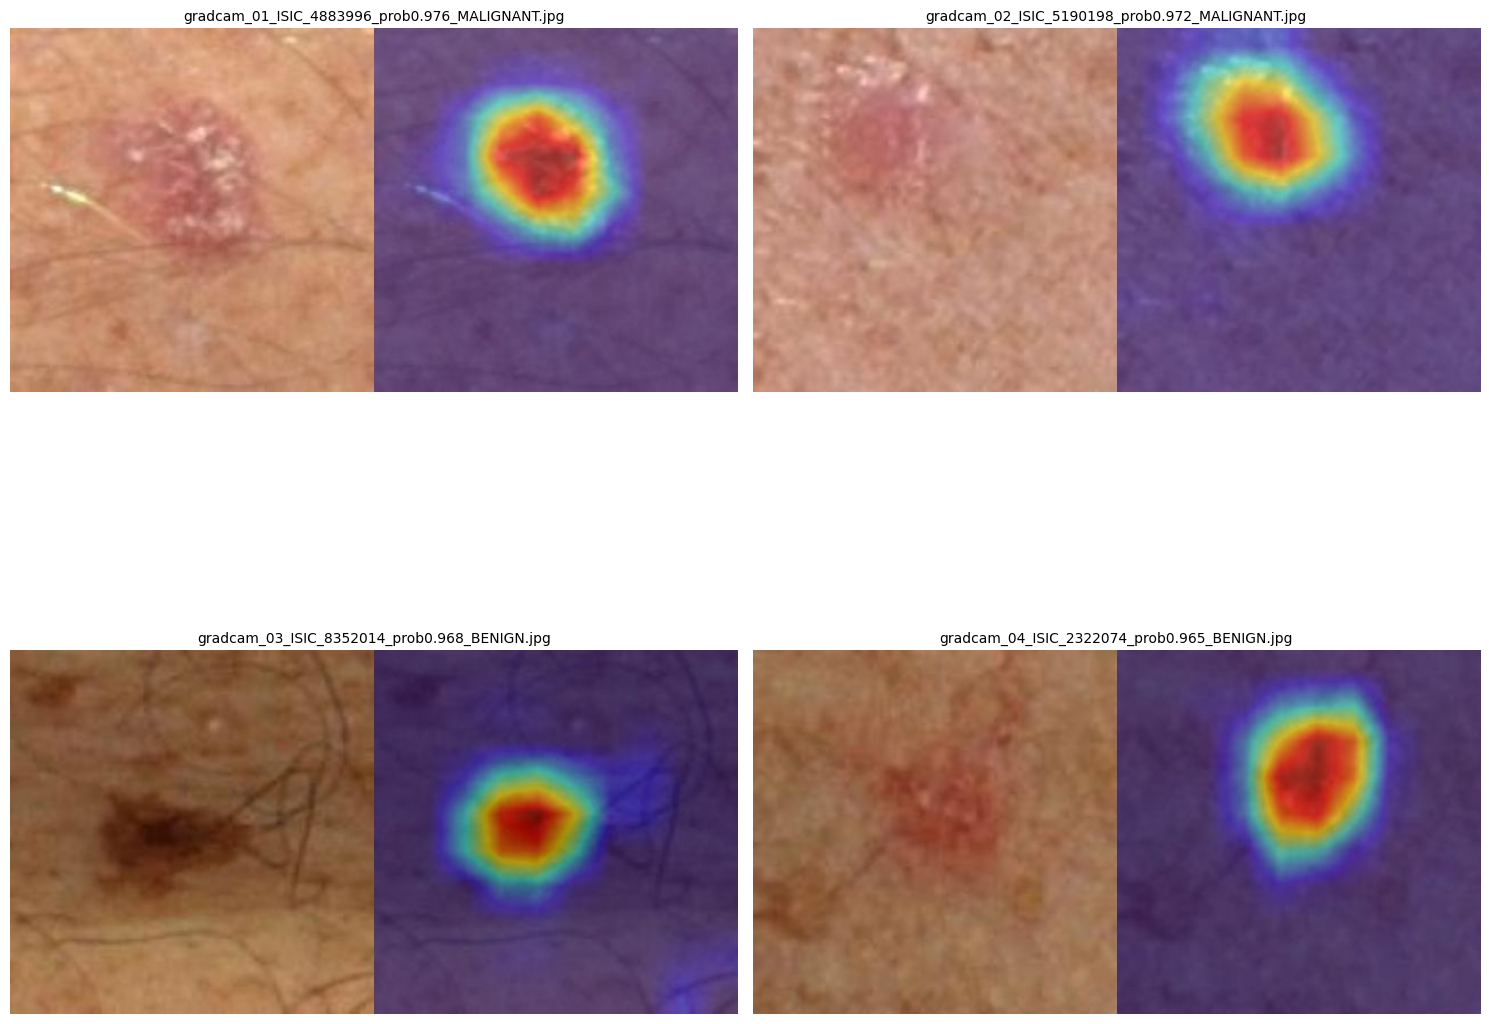

Summary figure saved to: /kaggle/working/skin_outputs/gradcam_summary.png
ALL PROCESSING COMPLETE!


In [55]:
print("\n" + "="*70)
print("Generating Grad-CAM visualizations...")
print("="*70)

activations = None
gradients = None

def find_target_conv(model):
    """Find the last convolutional layer for Grad-CAM"""
    for name, m in reversed(list(model.named_modules())):
        if isinstance(m, nn.Conv2d):
            return m, name
    return None, None

def register_hooks(model, layer):
    """Register forward and backward hooks"""
    global activations, gradients
    activations = None
    gradients = None
    
    def forward_hook(module, inp, out):
        global activations
        activations = out.detach()
    
    def backward_hook(module, grad_in, grad_out):
        global gradients
        gradients = grad_out[0].detach()
    
    h1 = layer.register_forward_hook(forward_hook)
    h2 = layer.register_full_backward_hook(backward_hook)
    return h1, h2

def generate_gradcam(model, img_tensor):
    """Generate Grad-CAM heatmap"""
    global activations, gradients
    model.eval()
    
    x = img_tensor.unsqueeze(0).to(CFG.DEVICE)
    x.requires_grad = True
    
    # Forward pass
    logits = model(x)
    score = logits[0]
    
    # Backward pass
    model.zero_grad()
    score.backward(retain_graph=False)
    
    if activations is None or gradients is None:
        return np.zeros((CFG.IMG_SIZE, CFG.IMG_SIZE), dtype=np.float32)
    
    # Compute Grad-CAM
    weights = gradients.mean(dim=(2,3), keepdim=True)
    cam = (weights * activations).sum(dim=1).squeeze().cpu().numpy()
    cam = np.maximum(cam, 0)
    cam = cv2.resize(cam, (CFG.IMG_SIZE, CFG.IMG_SIZE))
    
    # Normalize
    if cam.max() > 0:
        cam = (cam - cam.min()) / (cam.max() - cam.min())
    
    return cam

def save_gradcam_overlay(img_tensor, cam, outpath, alpha=0.5):
    """Save Grad-CAM overlay image"""
    # Denormalize image
    img_np = img_tensor.cpu().numpy()
    mean = np.array([0.485, 0.456, 0.406])[:, None, None]
    std = np.array([0.229, 0.224, 0.225])[:, None, None]
    img_denorm = np.clip((img_np * std + mean) * 255, 0, 255).astype(np.uint8)
    img_denorm = np.transpose(img_denorm, (1, 2, 0))
    
    # Create heatmap
    heatmap = cv2.applyColorMap(np.uint8(255 * cam), cv2.COLORMAP_JET)
    heatmap = cv2.cvtColor(heatmap, cv2.COLOR_BGR2RGB)
    
    # Overlay
    overlay = np.uint8(heatmap * alpha + img_denorm * (1 - alpha))
    
    # Combine original and overlay side by side
    combined = np.concatenate([img_denorm, overlay], axis=1)
    
    Image.fromarray(combined).save(outpath)
    return combined

# Find target layer
target_layer, layer_name = find_target_conv(model.backbone)

if target_layer is None:
    print(" Could not find conv layer for Grad-CAM")
else:
    print(f"✓ Using target layer: {layer_name}")
    
    # Generate Grad-CAMs for top predictions
    num_to_save = min(12, len(probs_test))
    top_idx = np.argsort(-probs_test)[:num_to_save]
    
    print(f"\nGenerating Grad-CAM for top {num_to_save} predictions")
    
    successful_saves = 0
    for i, idx in enumerate(tqdm(top_idx, desc="Generating Grad-CAMs")):
        img_id = ids_test[idx]
        prob = probs_test[idx]
        true_label = int(y_test[idx])
        
        path = os.path.join(CFG.IMG_DIR, str(img_id) + ".jpg")
        
        try:
            # Load and transform image
            img = cv2.imread(path)
            if img is None:
                print(f" Could not load image: {img_id}")
                continue
                
            img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
            img_t = val_tf(image=img)['image']
            
            # Register hooks
            h1, h2 = register_hooks(model, target_layer)
            
            # Generate Grad-CAM
            cam = generate_gradcam(model, img_t)
            
            # Save overlay
            label_str = "MALIGNANT" if true_label == 1 else "BENIGN"
            filename = f"gradcam_{i+1:02d}_{img_id}_prob{prob:.3f}_{label_str}.jpg"
            outpath = os.path.join(CFG.GRADCAM_DIR, filename)
            
            save_gradcam_overlay(img_t, cam, outpath)
            
            # Remove hooks
            h1.remove()
            h2.remove()
            
            successful_saves += 1
            
        except Exception as e:
            print(f" Error processing {img_id}: {str(e)}")
            continue
    
    print(f"\n Successfully saved {successful_saves}/{num_to_save} Grad-CAM visualizations")
    print(f" Saved to: {CFG.GRADCAM_DIR}")
    
    # Display sample Grad-CAMs
    if successful_saves > 0:
        print("\nSample Grad-CAMs (first 4):")
        fig, axes = plt.subplots(2, 2, figsize=(15, 15))
        axes = axes.flatten()
        
        saved_files = sorted([f for f in os.listdir(CFG.GRADCAM_DIR) if f.endswith('.jpg')])[:4]
        
        for idx, filename in enumerate(saved_files):
            img_path = os.path.join(CFG.GRADCAM_DIR, filename)
            img = Image.open(img_path)
            axes[idx].imshow(img)
            axes[idx].set_title(filename, fontsize=10)
            axes[idx].axis('off')
        
        plt.tight_layout()
        plt.savefig(os.path.join(CFG.OUT_DIR, 'gradcam_summary.png'), dpi=100, bbox_inches='tight')
        plt.show()
        print(f"Summary figure saved to: {os.path.join(CFG.OUT_DIR, 'gradcam_summary.png')}")

print("ALL PROCESSING COMPLETE!")